# Gazprom Neft SmartOil Contest
## Описание инсайтов команды "Шоколадные Бурильщики"

Здесь собраны наши лучшие идеи по первой части соревнований https://boosters.pro/gazprom_smartoil_contest

Мы надеемся, что данное описание поможет кому-нибудь занять призовое место.
Этот ноутбук создан в лучших традициях kaggle с целью поделиться опытом и принести пользу сообществу.

Соревнование было интересно тем, что дает возможность попробовать свои силы с маленькими промышленными данными.

По результатам финальных сабмитов наша команда заняла 12 и 17 места соответственно. 
Однако, среди не выбраных для финала сабмитов были решения тянувшие в первой задаче на 6 место по приватному лидерборду.

Чтобы было проще показать некоторые размышления подгрузим и предобработаем данные.

In [63]:
import pandas as pd
import numpy as np
%matplotlib inline

train = pd.read_csv('input/task1_data/train_1.8.csv')
train_2 = pd.read_csv('input/task2_data/train_2.7.csv')

In [64]:
for col in ['Нефтьт', 'Дебит попутного газам3/сут']:
    train[col] = train[col].str.replace(',', '.').astype(float)
    train_2[col] = train_2[col].str.replace(',', '.').astype(float)


train['target'] = train['Нефтьт'] / train['Время работыч']
train_2['target'] = train_2['Нефтьт'] / train_2['Время работыч']


0    0.925415
1    1.492694
2    1.406989
3    1.210954
4    1.057944
Name: target, dtype: float64

### Baseline

Первое, на что намекает использованная в соревнованиях метрика качества MAE - это посчитать средние значения дебита нефти по месяцам и отправить сабмит на проверку. Это давало лучший результат по сравнению с предсказанием самой целевой переменной "Нефть,т".

Если посмотреть на колонку "Время работы,ч", то станет ясно, что все скважины в месяце работали разное время. Отсюда, следует вывод, что будет не правильно предсказывать значение "Нефть,т", нужно найти производительность скважины в час и использовать это в качестве целевой переменной. 


In [39]:
train['Время работыч'].head()

0    301.0
1    720.0
2    744.0
3    744.0
4    720.0
Name: Время работыч, dtype: float64

In [65]:
train['target'].head()

0    0.925415
1    1.492694
2    1.406989
3    1.210954
4    1.057944
Name: target, dtype: float64

Если сложить воедино два предыдущих пункта, то логичным выглядит предсказывать не производительность скважины в единицу времени, а отклонение этой производительности от среднего.
Это хорошо, потому что тогда мы можем отдельным коэффициентом регулировать вклад модели в итогове предсказание.
По крайней мере на публичной части лидерборда это работало. =) Привет переобучение. Но можно ползти по лидерборду вверх и нервировать коллег по цеху.

Итого:

предсказание в месяце n = среднее значение в месяце n + поправочный коэффициент * предсказание модели тонн / час * количество часов в месяце

### Валидация

Наличие в тестовой выборке лишь одного месяца наталкивает на стратегию построения обучающей выборки, при которой:
1. Для первой задачи необходимо брать первый месяц для признаков. 
2. Для второй задачи необходимо взять первые 7 точек. Использовать значения признаков 1 месяца на следующие 6. Это исходит из потребности организаторов предсказывать результат после месяца проведения ГРП.
3. Так как разработка месторождения происходит кустовым способом. То логично разделить кусты в тренировочных и валидационных выборках. Но признак куста у нас в большинстве случаев не заполнен, поэтому нужен другой универсальный способ. Мы можем воспользоваться временем и использовать TimeSeriesSplit(n_splits = 5), так чтобы скважины в кустах не перемешивались. И скважины из будущего не влияли на скважины в прошлом.

Так как для решения второй задачи были доступны довольно длительные временные промежутки, то выглядит хорошей идеей сформировать большую обучающую выборку за счет поиска пиков, потенциально соответсвующих месяцам проведения ГРП.

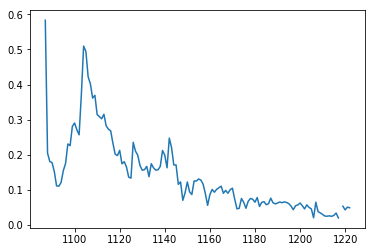

In [74]:
train_2[train_2['Скважина'] == '3bc5b6961aa997a89db8e760f1d304b2']['target'].plot()

### Очистка данных

Для чистки данных применяли только удаление тех скважин, по которым отсутсвует значение в колонке "Нефть,т". Можно считать такой способ не совсем полным, потенциально мы могли терять некоторые примеры из обучающей выборки.

### Дополнительные признаки

Хорошо себя показал признак плотность нефти. Однако, для тренировочной выборки его нужно было посчитать самостоятельно, а для тестовой он присуствовал почти полностью и без пропусков.


In [75]:
train[['Плотность нефти', 'Нефтьм3', 'Нефтьт']][~train['Нефтьт'].isnull()].head(10)

,Плотность нефти,Нефтьм3,Нефтьт
0,NaN,"320,17",278.55
1,0.87,"1235,33",1074.74
2,0.87,"1203,22",1046.80
3,0.87,"1035,57",900.95
4,0.87,"875,54",761.72
5,0.87,"749,32",651.91
12,NaN,"0,00",0.00
13,NaN,"760,01",661.20
14,0.87,"1752,88",1525.00
15,0.87,"2695,58",2345.15


Среди фичей присуствует "Дебит попутного газам3/сут" по важности признаков он занимает лидирующее место. Среди всех признаков про газ, решено было оставить только его. Он показывал поразительную важность ~0.8.

В качестве дополнительных признаков добавляли в обучающую выборку кодирование средним значением таргета по кластерам координат устьев и пластов. Это давало плоды и на кросс валидации и на публичном лидерборде. 

### Еще таргеты

Буквально за неделю до кончания соревнований, на МЛ тренировке в Екатеринбурге мы пришли к интересному заключению.
Если отобразить зависимость рассчитанного ранее дебита нефти от "Дебит попутного газам3/сут", то мы увидим следующую картину:

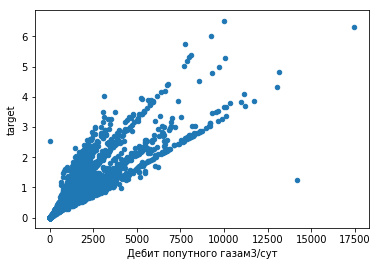

In [43]:
train.plot.scatter(y='target', x='Дебит попутного газам3/сут')

Это наталкивает на мысли сделать еще один таргет и усреднить предсказания с предсказанием производительности.

Дополнительным таргетом выступает линейный коэффициент зависимости нефти от дебита газа. 
Для скважин одного куста или одного пласта предыдущий гарфик может выглядеть следующим образом:

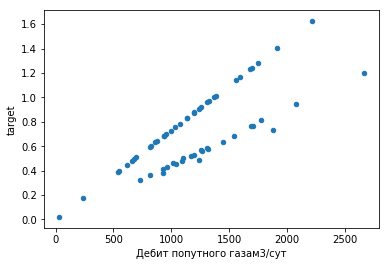

In [53]:
train[train['Куст'] == '130'].plot.scatter(y='target', x='Дебит попутного газам3/сут')

Это значит, что имея на руках всего лишь коэффициент и значение для дебита газа можно очень точно предсказывать дебит нефти для скважины или куста скважин.
Значение коэффициента легко найти через МНК из statsmodels.

### Не решенные проблемы
На таких малых данных оказалось сложно проводить отбор признаков и подбирать гиперпараметры моделей. Обилие признаков только усложняло задачу.

Окончательно не разобрались как использовать las файлы. 
Выделили в качестве бинарных признаков наличие колонок las файлов и посчитали статискики по колонкам(средние, максимумы).

Не придумали как заполнить пропуски для тех скважин, где есть газ и газ отсутвует.
Были идеи сделать две модели, одна делает предсказание с газом, другая без газа.

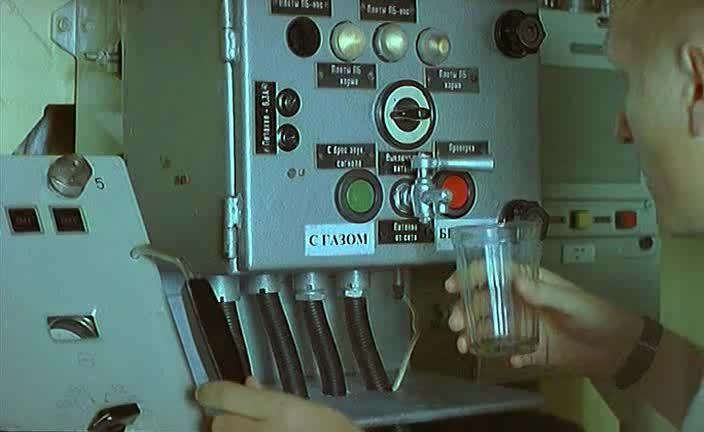

Список дополнительных гипотез, которые не дали сильного прироста качества или до которых не дошли руки:
    
1. Сделать аналитический расчет дебита исходя из доступных признаков.
2. Сформировать признаки путем комбинаций всех признаков друг с другом. В топ важности вылезали удивительные признаки вида: Номер бригады * Напор. Использование таких признаков привело бы к переобучению.
3. Предсказывать дебит не только нефти, так же жидкости и воды.
4. Найти корреляции межуд лас файлами и признаками обучающей выборки.
5. Использовать наличие нагнетательных скважин.
6. Использовать две модели. Одна предсказывает первый месяц, вторая коэффициент зависимости нефти от газа.
7. Использовать факт, что со временем месторождения мельчают и размер микропор породы также уменьшается.
8. Автоматически убирать низковариативные признаки.
9. Некторые скважины могут закрываться ввиду из экономической нецелесообразности.
10. Использовать данные одной задачи для решения другой.